In [4]:
import numpy as np
import matplotlib.pyplot as plt

import onix.models.hyperfine as hyperfine

B_field = 270e-4
ground = hyperfine.states["7F0"]
ground._Hamiltonian = ground.H_total(B_field)
excited = hyperfine.states["5D0"]
excited._Hamiltonian = excited.H_total(B_field)

In [136]:
hyperfine_branchings = hyperfine.get_optical_hyperfine_probabilities(B_field)
lifetime = 2e-3
mode = "branching"  # "branching", "vertical", "average"

In [137]:
class Step:
    def __init__(self, pops, starts, ends, duration, total_time_constant):
        self.pops = pops
        try:
            len(starts)
        except TypeError:
            starts = [starts]
        self.starts = starts
        try:
            len(ends)
        except TypeError:
            ends = [ends]
        self.ends = ends
        self.duration = duration
        self.total_time_constant = total_time_constant
        time_constants = []
        for kk, e in enumerate(excited.states):
            for ll, g in enumerate(ground.states):
                if mode == "branching":
                    branching = hyperfine_branchings[g][e]
                elif mode == "vertical":
                    if kk % 2 == ll % 2:
                        branching = 1/3
                    else:
                        branching = 1e-10
                elif mode == "average":
                    branching = 1/6
                time_constants.append(
                    (kk + 6, ll, lifetime / branching)
                )
        self._decay_time_constants = time_constants

    def evolute(self, pops, t_step):
        time_constants = []
        for end in self.ends:
            for start in self.starts:
                if end < 6:  # rf
                    time_constants.append((start, end, self.total_time_constant))
                else:
                    g = ground.states[start]
                    e = excited.states[end - 6]
                    time_constants.append(
                        (start, end, self.total_time_constant / hyperfine_branchings[g][e])
                    )
        time_constants.extend(self._decay_time_constants)
        for start, end, time_constant in time_constants:
            if start < 6 and end >= 6:
                diff = (pops[start] - pops[end]) / 2 * t_step / time_constant  # optical pumping
            elif start < 6 and end < 6:
                diff = (pops[start] - pops[end]) * t_step / time_constant  # rf sweep
            else:
                diff = pops[start] * t_step / time_constant  # decay
            pops[start] -= diff
            pops[end] += diff
        return pops

    def simulate(self, t_start=0):
        steps = 100
        t_step_1 = lifetime / steps
        t_step_2 = self.total_time_constant / steps
        t_step = np.min([t_step_1, t_step_2])
        t_step = self.duration / (int(self.duration / t_step) + 1)
        ts = []
        all_pops = []
        pops = self.pops.copy()
        t = t_start
        while t < t_start + self.duration:
            pops = self.evolute(pops, t_step)
            t += t_step
            ts.append(t)
            all_pops.append(pops.copy())
        return np.array(ts), np.array(all_pops)

In [138]:
class Simulation:
    def __init__(self, pops, total_time_constant):
        self.pops = pops
        self.total_time_constant = total_time_constant
        self.steps = []

    def add_step(self, starts, ends, duration, total_time_constant = None):
        self.steps.append((starts, ends, duration, total_time_constant))

    def simulate(self):
        ts = []
        all_pops = np.empty((0, 12))
        pops = self.pops.copy()
        t = 0
        for starts, ends, duration, total_time_constant in self.steps:
            if total_time_constant is None:
                total_time_constant = self.total_time_constant
            step = Step(pops, starts, ends, duration, total_time_constant)
            new_ts, new_all_pops = step.simulate(t)
            t = new_ts[-1] * 2 - new_ts[-2]
            pops = new_all_pops[-1]
            ts = np.append(ts, new_ts)
            all_pops = np.append(all_pops, new_all_pops, axis=0)
        return ts, all_pops

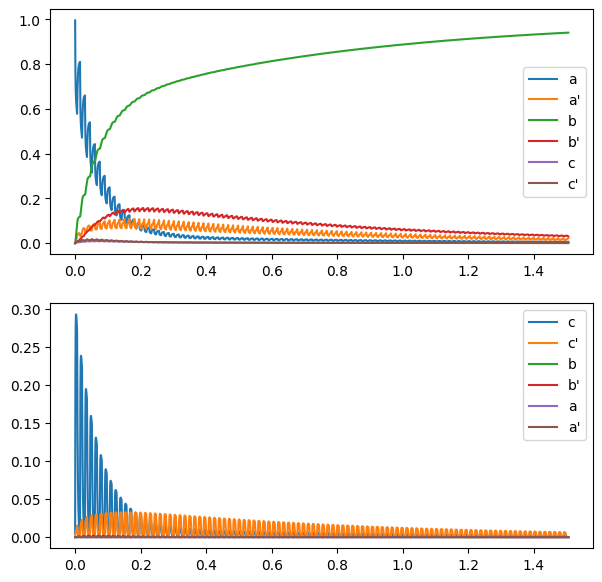

In [140]:
pops = np.zeros(12)
pops[0] = 1
s = Simulation(pops, 1e-3)
for kk in range(100):
    s.add_step([0, 1], [6, 7], 6e-3)
    s.add_step([4, 5], [8, 9], 6e-3)
    s.add_step(3, 1, 3e-3, 10e-3)
ts, all_pops = s.simulate()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))
ax1.plot(ts, all_pops[:,:6], label=ground.states)
ax2.plot(ts, all_pops[:,6:], label=excited.states)
ax1.legend()
ax2.legend()
plt.show()

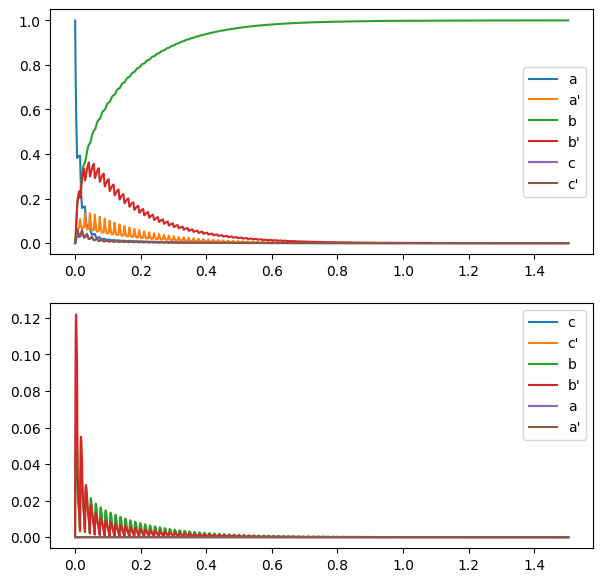

In [142]:
pops = np.zeros(12)
pops[0] = 1
s = Simulation(pops, 0.25e-3)
for kk in range(100):
    s.add_step([0, 1], [8, 9], 6e-3)
    s.add_step([4, 5], [8, 9], 6e-3)
    s.add_step(3, 1, 3e-3, 10e-3)
ts, all_pops = s.simulate()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))
ax1.plot(ts, all_pops[:,:6], label=ground.states)
ax2.plot(ts, all_pops[:,6:], label=excited.states)
ax1.legend()
ax2.legend()
plt.show()